# 1. Import and Install Dependencies

In [1]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib

  Using cached mediapipe-0.9.0.1-cp310-cp310-win_amd64.whl (49.8 MB)
  Using cached opencv_contrib_python-4.7.0.68-cp37-abi3-win_amd64.whl (44.9 MB)


In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [3]:
# Holistic model
mp_holistic = mp.solutions.holistic

# Drawing utilities
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image,model):
    
    # Color conversion BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Image is no longer writeable
    image.flags.writeable = False
    
    # Make prediction
    results = model.process(image)
    
    # Image is now writeable
    image.flags.writeable = True
    
    # Color conversion RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    return image, results

In [5]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [6]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)
                             )
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             )
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             )    
                            

In [8]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image,results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [11]:
cap.release()
cv2.destroyAllWindows()

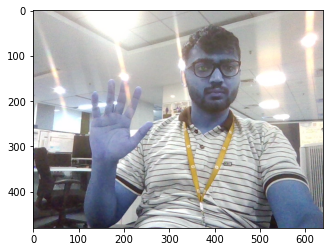

In [35]:
plt.imshow(frame)

In [36]:
draw_landmarks(frame, results)

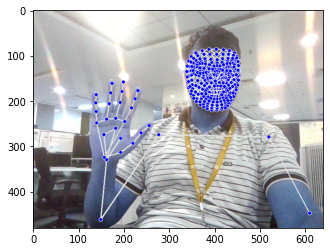

In [37]:
plt.imshow(frame)

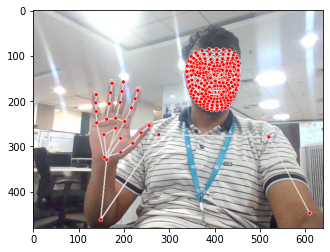

In [38]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [11]:
results

mediapipe.python.solution_base.SolutionOutputs

In [18]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [19]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face, lh, rh])

In [42]:
extract_keypoints(results).shape

(1662,)

# 4. Setup Folders for Collection

In [11]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['hello','thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [12]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: 
    
    # Loop through actions
    for action in actions:
        
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                
                # Read feed
                ret, frame = cap.read()
                
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)
                
                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # Apply collection logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT-HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                
                # Export keypoints    
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
                
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [20]:
label_map = {label:num for num, label in enumerate(actions)}

In [21]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [22]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [49]:
np.array(sequences).shape

(90, 30, 1662)

In [50]:
np.array(labels).shape

(90,)

In [51]:
X = np.array(sequences)

In [52]:
X.shape

(90, 30, 1662)

In [53]:
y = to_categorical(labels).astype(int)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [55]:
X_train.shape

(85, 30, 1662)

In [56]:
X_test.shape

(5, 30, 1662)

In [57]:
y_train.shape

(85, 3)

In [58]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [9]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [13]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape = (30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [63]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 3s 76ms/step - loss: 1.1479 - categorical_accuracy: 0.3059
Epoch 2/2000
3/3 [==============================] - 0s 67ms/step - loss: 1.5200 - categorical_accuracy: 0.3294
Epoch 3/2000
3/3 [==============================] - 0s 65ms/step - loss: 0.8715 - categorical_accuracy: 0.3529
Epoch 4/2000
3/3 [==============================] - 0s 64ms/step - loss: 1.1549 - categorical_accuracy: 0.3294
Epoch 5/2000
3/3 [==============================] - 0s 66ms/step - loss: 2.8927 - categorical_accuracy: 0.4000
Epoch 6/2000
3/3 [==============================] - 0s 67ms/step - loss: 2.6043 - categorical_accuracy: 0.4588
Epoch 7/2000
3/3 [==============================] - 0s 61ms/step - loss: 1.5103 - categorical_accuracy: 0.3882
Epoch 8/2000
3/3 [==============================] - 0s 66ms/step - loss: 1.2623 - categorical_accuracy: 0.3176
Epoch 9/2000
3/3 [==============================] - 0s 65ms/step - loss: 1.4432 - categorical_accuracy: 0.3412
E

3/3 [==============================] - 0s 75ms/step - loss: 0.0545 - categorical_accuracy: 0.9882
Epoch 147/2000
3/3 [==============================] - 0s 80ms/step - loss: 0.0176 - categorical_accuracy: 1.0000
Epoch 148/2000
3/3 [==============================] - 0s 75ms/step - loss: 0.0216 - categorical_accuracy: 1.0000
Epoch 149/2000
3/3 [==============================] - 0s 85ms/step - loss: 0.0385 - categorical_accuracy: 0.9882
Epoch 150/2000
3/3 [==============================] - 0s 73ms/step - loss: 0.0197 - categorical_accuracy: 1.0000
Epoch 151/2000
3/3 [==============================] - 0s 77ms/step - loss: 0.0214 - categorical_accuracy: 1.0000
Epoch 152/2000
3/3 [==============================] - 0s 68ms/step - loss: 0.0349 - categorical_accuracy: 0.9882
Epoch 153/2000
3/3 [==============================] - 0s 71ms/step - loss: 0.0196 - categorical_accuracy: 0.9882
Epoch 154/2000
3/3 [==============================] - 0s 77ms/step - loss: 0.0356 - categorical_accuracy: 0.976

3/3 [==============================] - 0s 67ms/step - loss: 3.0955e-05 - categorical_accuracy: 1.0000
Epoch 287/2000
3/3 [==============================] - 0s 72ms/step - loss: 3.0703e-05 - categorical_accuracy: 1.0000
Epoch 288/2000
3/3 [==============================] - 0s 70ms/step - loss: 3.0317e-05 - categorical_accuracy: 1.0000
Epoch 289/2000
3/3 [==============================] - 0s 69ms/step - loss: 3.0162e-05 - categorical_accuracy: 1.0000
Epoch 290/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.9839e-05 - categorical_accuracy: 1.0000
Epoch 291/2000
3/3 [==============================] - 0s 68ms/step - loss: 2.9528e-05 - categorical_accuracy: 1.0000
Epoch 292/2000
3/3 [==============================] - 0s 70ms/step - loss: 2.9406e-05 - categorical_accuracy: 1.0000
Epoch 293/2000
3/3 [==============================] - 0s 70ms/step - loss: 2.8906e-05 - categorical_accuracy: 1.0000
Epoch 294/2000
3/3 [==============================] - 0s 72ms/step - loss: 2.86

3/3 [==============================] - 0s 70ms/step - loss: 1.1138e-05 - categorical_accuracy: 1.0000
Epoch 427/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.1104e-05 - categorical_accuracy: 1.0000
Epoch 428/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.1040e-05 - categorical_accuracy: 1.0000
Epoch 429/2000
3/3 [==============================] - 0s 69ms/step - loss: 1.0935e-05 - categorical_accuracy: 1.0000
Epoch 430/2000
3/3 [==============================] - 0s 66ms/step - loss: 1.0926e-05 - categorical_accuracy: 1.0000
Epoch 431/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.0877e-05 - categorical_accuracy: 1.0000
Epoch 432/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.0803e-05 - categorical_accuracy: 1.0000
Epoch 433/2000
3/3 [==============================] - 0s 69ms/step - loss: 1.0712e-05 - categorical_accuracy: 1.0000
Epoch 434/2000
3/3 [==============================] - 0s 68ms/step - loss: 1.07

3/3 [==============================] - 0s 71ms/step - loss: 5.1452e-06 - categorical_accuracy: 1.0000
Epoch 567/2000
3/3 [==============================] - 0s 69ms/step - loss: 5.1031e-06 - categorical_accuracy: 1.0000
Epoch 568/2000
3/3 [==============================] - 0s 70ms/step - loss: 5.0652e-06 - categorical_accuracy: 1.0000
Epoch 569/2000
3/3 [==============================] - 0s 72ms/step - loss: 5.0610e-06 - categorical_accuracy: 1.0000
Epoch 570/2000
3/3 [==============================] - 0s 70ms/step - loss: 5.0246e-06 - categorical_accuracy: 1.0000
Epoch 571/2000
3/3 [==============================] - 0s 65ms/step - loss: 5.0035e-06 - categorical_accuracy: 1.0000
Epoch 572/2000
3/3 [==============================] - 0s 72ms/step - loss: 4.9713e-06 - categorical_accuracy: 1.0000
Epoch 573/2000
3/3 [==============================] - 0s 68ms/step - loss: 4.9376e-06 - categorical_accuracy: 1.0000
Epoch 574/2000
3/3 [==============================] - 0s 66ms/step - loss: 4.91

3/3 [==============================] - 0s 80ms/step - loss: 2.0685e-06 - categorical_accuracy: 1.0000
Epoch 707/2000
3/3 [==============================] - 0s 68ms/step - loss: 2.0629e-06 - categorical_accuracy: 1.0000
Epoch 708/2000
3/3 [==============================] - 0s 71ms/step - loss: 2.0391e-06 - categorical_accuracy: 1.0000
Epoch 709/2000
3/3 [==============================] - 0s 69ms/step - loss: 2.0321e-06 - categorical_accuracy: 1.0000
Epoch 710/2000
3/3 [==============================] - 0s 71ms/step - loss: 2.0152e-06 - categorical_accuracy: 1.0000
Epoch 711/2000
3/3 [==============================] - 0s 75ms/step - loss: 2.0012e-06 - categorical_accuracy: 1.0000
Epoch 712/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.9914e-06 - categorical_accuracy: 1.0000
Epoch 713/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.9788e-06 - categorical_accuracy: 1.0000
Epoch 714/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.96

3/3 [==============================] - 0s 83ms/step - loss: 9.7748e-07 - categorical_accuracy: 1.0000
Epoch 847/2000
3/3 [==============================] - 0s 77ms/step - loss: 9.7047e-07 - categorical_accuracy: 1.0000
Epoch 848/2000
3/3 [==============================] - 0s 71ms/step - loss: 9.6626e-07 - categorical_accuracy: 1.0000
Epoch 849/2000
3/3 [==============================] - 0s 72ms/step - loss: 9.6065e-07 - categorical_accuracy: 1.0000
Epoch 850/2000
3/3 [==============================] - 0s 72ms/step - loss: 9.5785e-07 - categorical_accuracy: 1.0000
Epoch 851/2000
3/3 [==============================] - 0s 74ms/step - loss: 9.5364e-07 - categorical_accuracy: 1.0000
Epoch 852/2000
3/3 [==============================] - 0s 78ms/step - loss: 9.5084e-07 - categorical_accuracy: 1.0000
Epoch 853/2000
3/3 [==============================] - 0s 69ms/step - loss: 9.4663e-07 - categorical_accuracy: 1.0000
Epoch 854/2000
3/3 [==============================] - 0s 71ms/step - loss: 9.45

3/3 [==============================] - 0s 72ms/step - loss: 6.2829e-07 - categorical_accuracy: 1.0000
Epoch 987/2000
3/3 [==============================] - 0s 83ms/step - loss: 6.2408e-07 - categorical_accuracy: 1.0000
Epoch 988/2000
3/3 [==============================] - 0s 81ms/step - loss: 6.2268e-07 - categorical_accuracy: 1.0000
Epoch 989/2000
3/3 [==============================] - 0s 76ms/step - loss: 6.2128e-07 - categorical_accuracy: 1.0000
Epoch 990/2000
3/3 [==============================] - 0s 79ms/step - loss: 6.1987e-07 - categorical_accuracy: 1.0000
Epoch 991/2000
3/3 [==============================] - 0s 75ms/step - loss: 6.1847e-07 - categorical_accuracy: 1.0000
Epoch 992/2000
3/3 [==============================] - 0s 73ms/step - loss: 6.1567e-07 - categorical_accuracy: 1.0000
Epoch 993/2000
3/3 [==============================] - 0s 72ms/step - loss: 6.1426e-07 - categorical_accuracy: 1.0000
Epoch 994/2000
3/3 [==============================] - 0s 71ms/step - loss: 6.11

3/3 [==============================] - 0s 75ms/step - loss: 4.4738e-07 - categorical_accuracy: 1.0000
Epoch 1125/2000
3/3 [==============================] - 0s 72ms/step - loss: 4.4598e-07 - categorical_accuracy: 1.0000
Epoch 1126/2000
3/3 [==============================] - 0s 76ms/step - loss: 4.4457e-07 - categorical_accuracy: 1.0000
Epoch 1127/2000
3/3 [==============================] - 0s 73ms/step - loss: 4.4317e-07 - categorical_accuracy: 1.0000
Epoch 1128/2000
3/3 [==============================] - 0s 74ms/step - loss: 4.4317e-07 - categorical_accuracy: 1.0000
Epoch 1129/2000
3/3 [==============================] - 0s 73ms/step - loss: 4.4177e-07 - categorical_accuracy: 1.0000
Epoch 1130/2000
3/3 [==============================] - 0s 72ms/step - loss: 4.4037e-07 - categorical_accuracy: 1.0000
Epoch 1131/2000
3/3 [==============================] - 0s 69ms/step - loss: 4.4037e-07 - categorical_accuracy: 1.0000
Epoch 1132/2000
3/3 [==============================] - 0s 74ms/step - lo

3/3 [==============================] - 0s 74ms/step - loss: 3.3659e-07 - categorical_accuracy: 1.0000
Epoch 1263/2000
3/3 [==============================] - 0s 75ms/step - loss: 3.3518e-07 - categorical_accuracy: 1.0000
Epoch 1264/2000
3/3 [==============================] - 0s 81ms/step - loss: 3.3518e-07 - categorical_accuracy: 1.0000
Epoch 1265/2000
3/3 [==============================] - 0s 83ms/step - loss: 3.3518e-07 - categorical_accuracy: 1.0000
Epoch 1266/2000
3/3 [==============================] - 0s 82ms/step - loss: 3.3378e-07 - categorical_accuracy: 1.0000
Epoch 1267/2000
3/3 [==============================] - 0s 82ms/step - loss: 3.3378e-07 - categorical_accuracy: 1.0000
Epoch 1268/2000
3/3 [==============================] - 0s 84ms/step - loss: 3.3238e-07 - categorical_accuracy: 1.0000
Epoch 1269/2000
3/3 [==============================] - 0s 82ms/step - loss: 3.3098e-07 - categorical_accuracy: 1.0000
Epoch 1270/2000
3/3 [==============================] - 0s 76ms/step - lo

3/3 [==============================] - 0s 74ms/step - loss: 2.5805e-07 - categorical_accuracy: 1.0000
Epoch 1401/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 1402/2000
3/3 [==============================] - 0s 74ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 1403/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 1404/2000
3/3 [==============================] - 0s 74ms/step - loss: 2.5665e-07 - categorical_accuracy: 1.0000
Epoch 1405/2000
3/3 [==============================] - 0s 73ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 1406/2000
3/3 [==============================] - 0s 76ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 1407/2000
3/3 [==============================] - 0s 72ms/step - loss: 2.5525e-07 - categorical_accuracy: 1.0000
Epoch 1408/2000
3/3 [==============================] - 0s 74ms/step - lo

3/3 [==============================] - 0s 84ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1539/2000
3/3 [==============================] - 0s 79ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1540/2000
3/3 [==============================] - 0s 87ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1541/2000
3/3 [==============================] - 0s 82ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1542/2000
3/3 [==============================] - 0s 82ms/step - loss: 2.0195e-07 - categorical_accuracy: 1.0000
Epoch 1543/2000
3/3 [==============================] - 0s 79ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 1544/2000
3/3 [==============================] - 0s 78ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 1545/2000
3/3 [==============================] - 0s 76ms/step - loss: 2.0055e-07 - categorical_accuracy: 1.0000
Epoch 1546/2000
3/3 [==============================] - 0s 78ms/step - lo

3/3 [==============================] - 0s 71ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1677/2000
3/3 [==============================] - 0s 74ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1678/2000
3/3 [==============================] - 0s 71ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1679/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1680/2000
3/3 [==============================] - 0s 74ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1681/2000
3/3 [==============================] - 0s 73ms/step - loss: 1.5848e-07 - categorical_accuracy: 1.0000
Epoch 1682/2000
3/3 [==============================] - 0s 74ms/step - loss: 1.5707e-07 - categorical_accuracy: 1.0000
Epoch 1683/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.5707e-07 - categorical_accuracy: 1.0000
Epoch 1684/2000
3/3 [==============================] - 0s 80ms/step - lo

3/3 [==============================] - 0s 74ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1815/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1816/2000
3/3 [==============================] - 0s 78ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1817/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1818/2000
3/3 [==============================] - 0s 83ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1819/2000
3/3 [==============================] - 0s 80ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1820/2000
3/3 [==============================] - 0s 83ms/step - loss: 1.2762e-07 - categorical_accuracy: 1.0000
Epoch 1821/2000
3/3 [==============================] - 0s 79ms/step - loss: 1.2622e-07 - categorical_accuracy: 1.0000
Epoch 1822/2000
3/3 [==============================] - 0s 81ms/step - lo

3/3 [==============================] - 0s 76ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1953/2000
3/3 [==============================] - 0s 78ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1954/2000
3/3 [==============================] - 0s 74ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1955/2000
3/3 [==============================] - 0s 73ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1956/2000
3/3 [==============================] - 0s 72ms/step - loss: 9.8172e-08 - categorical_accuracy: 1.0000
Epoch 1957/2000
3/3 [==============================] - 0s 70ms/step - loss: 9.6770e-08 - categorical_accuracy: 1.0000
Epoch 1958/2000
3/3 [==============================] - 0s 75ms/step - loss: 9.6770e-08 - categorical_accuracy: 1.0000
Epoch 1959/2000
3/3 [==============================] - 0s 74ms/step - loss: 9.6770e-08 - categorical_accuracy: 1.0000
Epoch 1960/2000
3/3 [==============================] - 0s 72ms/step - lo

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

# 8. Make Predictions

In [65]:
res = model.predict(X_test)

1/1 [==============================] - 0s 358ms/step


In [70]:
actions[np.argmax(res[0])]

'iloveyou'

In [71]:
actions[np.argmax(y_test[0])]

'iloveyou'

# 9. Save Weights

In [72]:
model.save('action.h5')

In [14]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [73]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [91]:
yhat = model.predict(X_train) 

3/3 [==============================] - 0s 21ms/step


In [92]:
y_true = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [86]:
yhat

[2, 1, 1, 2, 2]

In [77]:
y_true

[2, 1, 1, 2, 2]

In [93]:
multilabel_confusion_matrix(y_true, yhat)

array([[[55,  0],
        [ 0, 30]],

       [[57,  0],
        [ 0, 28]],

       [[58,  0],
        [ 0, 27]]], dtype=int64)

In [94]:
accuracy_score(y_true,yhat)

1.0

# 11. Test in Real Time

In [15]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
    return output_frame

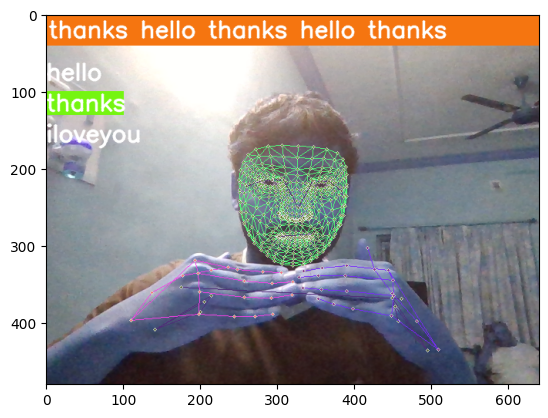

In [21]:
plt.imshow(prob_viz(res, actions, image, colors))

In [20]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image,results)
        
        # 2. Prediction Logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        
        # 3. Visualisation logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Visualisation probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyo

iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
ilov

thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
iloveyou
iloveyou
iloveyou
iloveyou
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
iloveyou
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
iloveyou
iloveyou
iloveyou
iloveyou
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
ilove

iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
ilov

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks


In [17]:
cap.release()
cv2.destroyAllWindows()